# Individual Poem Trajectory Visualizer

This notebook generates publication-quality trajectory visualizations for individual poems.

## Quick Start
1. Run cells 1-3 once (setup - takes ~2 minutes to load Word2Vec)
2. Change `POEM_FILENAME` in Cell 4 to the poem you want to visualize
3. Run cells 4-14 to generate complete analysis
4. For next poem, just change Cell 4 and rerun cells 4-14

## Key Poems for Case Studies
```python
'006_shall_i_compare_thee_to_a_summers_day.txt'  # Shakespeare (highest adjusted T)
'030_in_a_station_of_the_metro.txt'              # Pound (lowest adjusted T)
'024_my_last_duchess.txt'                        # Browning (narrative)
'033_gerontion.txt'                              # Eliot (modernist)
```

In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
from pathlib import Path
import json
import re
import gensim.downloader as api
from typing import List, Dict, Tuple, Optional

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✓ Imports loaded")

✓ Imports loaded


In [2]:
# Cell 2: Load Word2Vec Model (takes ~2 minutes)
print("Loading Word2Vec model... (this takes ~2 minutes)")
model = api.load('word2vec-google-news-300')
print("✓ Word2Vec model loaded")
print(f"  Vocabulary size: {len(model):,} words")
print(f"  Vector dimensions: {model.vector_size}")

Loading Word2Vec model... (this takes ~2 minutes)
✓ Word2Vec model loaded
  Vocabulary size: 3,000,000 words
  Vector dimensions: 300


In [3]:
# Cell 3: Define trajectory functions with JSON serialization fixes

def cosine_distance(v1: np.ndarray, v2: np.ndarray) -> float:
    """Calculate cosine distance between two vectors."""
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    if norm_product == 0:
        return 2.0
    return float(1.0 - (dot_product / norm_product))

def semantic_path_length(embeddings: np.ndarray) -> float:
    """Calculate total path length through semantic space."""
    distances = [cosine_distance(embeddings[i], embeddings[i+1]) 
                for i in range(len(embeddings)-1)]
    return float(sum(distances))

def net_semantic_displacement(embeddings: np.ndarray) -> float:
    """Calculate net displacement from start to end."""
    return cosine_distance(embeddings[0], embeddings[-1])

def tortuosity(embeddings: np.ndarray) -> float:
    """Calculate tortuosity (path length / displacement ratio)."""
    spl = semantic_path_length(embeddings)
    nsd = net_semantic_displacement(embeddings)
    if nsd == 0:
        return float('inf')
    return float(spl / nsd)

def return_to_origin(embeddings: np.ndarray) -> float:
    """Calculate distance from end point back to start."""
    return cosine_distance(embeddings[-1], embeddings[0])

def exploration_radius(embeddings: np.ndarray) -> float:
    """Calculate average distance from semantic centroid."""
    centroid = np.mean(embeddings, axis=0)
    distances = [cosine_distance(emb, centroid) for emb in embeddings]
    return float(np.mean(distances))

def velocity_profile_variance(embeddings: np.ndarray) -> float:
    """Calculate variance in step-to-step semantic distances."""
    distances = [cosine_distance(embeddings[i], embeddings[i+1]) 
                for i in range(len(embeddings)-1)]
    return float(np.var(distances))

def directional_consistency(embeddings: np.ndarray) -> float:
    """Calculate consistency of movement direction."""
    if len(embeddings) < 3:
        return 0.0
    
    directions = []
    for i in range(len(embeddings)-1):
        direction = embeddings[i+1] - embeddings[i]
        norm = np.linalg.norm(direction)
        if norm > 0:
            directions.append(direction / norm)
    
    if len(directions) < 2:
        return 0.0
    
    cosine_sims = []
    for i in range(len(directions)-1):
        cos_sim = np.dot(directions[i], directions[i+1])
        cosine_sims.append(cos_sim)
    
    return float(np.mean(cosine_sims))

def calculate_all_metrics(embeddings: np.ndarray, words: List[str] = None) -> Dict[str, float]:
    """Calculate all trajectory metrics for a sequence of embeddings."""
    n = len(embeddings)
    
    metrics = {
        'num_words': int(n),
        'spl': semantic_path_length(embeddings),
        'nsd': net_semantic_displacement(embeddings),
        'tortuosity': tortuosity(embeddings),
        'return_to_origin': return_to_origin(embeddings),
        'exploration_radius': exploration_radius(embeddings),
        'velocity_variance': velocity_profile_variance(embeddings),
        'directional_consistency': directional_consistency(embeddings)
    }
    
    # Add normalized SPL
    if n > 1:
        metrics['spl_normalized'] = float(metrics['spl'] / (n - 1))
    else:
        metrics['spl_normalized'] = 0.0
    
    return metrics

print("✓ Trajectory functions defined (with JSON serialization fixes)")

✓ Trajectory functions defined (with JSON serialization fixes)


In [15]:
# Cell 4: SELECT POEM HERE
# Change this filename to visualize different poems

POEM_FILENAME = '024_my_last_duchess.txt'

# Quick reference for key case studies:
# '006_shall_i_compare_thee_to_a_summers_day.txt'  # Shakespeare (highest adjusted T)
# '030_in_a_station_of_the_metro.txt'              # Pound (lowest adjusted T)
# '024_my_last_duchess.txt'                        # Browning (narrative)
# '033_gerontion.txt'                              # Eliot (modernist)

POEMS_DIR = Path('corpus_texts')
POEM_PATH = POEMS_DIR / POEM_FILENAME

print(f"Selected poem: {POEM_FILENAME}")
print(f"Path: {POEM_PATH}")

Selected poem: 024_my_last_duchess.txt
Path: corpus_texts/024_my_last_duchess.txt


In [16]:
# Cell 5: Load and process poem

def clean_text(text: str) -> List[str]:
    """Clean text and extract words."""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation but keep spaces
    text = re.sub(r'[^a-z\s]', '', text)
    # Split into words
    words = text.split()
    return words

def get_embeddings(words: List[str], model) -> Tuple[np.ndarray, List[str]]:
    """Get embeddings for words that exist in vocabulary."""
    valid_words = []
    embeddings = []
    
    for word in words:
        if word in model:
            valid_words.append(word)
            embeddings.append(model[word])
    
    if len(embeddings) == 0:
        return None, None
    
    return np.array(embeddings), valid_words

# Load poem
with open(POEM_PATH, 'r', encoding='utf-8') as f:
    poem_text = f.read()

# Process
words = clean_text(poem_text)
embeddings, valid_words = get_embeddings(words, model)

# Get title from first line
first_line = poem_text.split('\n')[0].strip()
if first_line:
    poem_title = first_line[:60]  # Truncate if too long
else:
    poem_title = POEM_FILENAME.replace('.txt', '').replace('_', ' ').title()

print(f"Poem: {poem_title}")
print(f"Total words: {len(words)}")
print(f"Valid words (in Word2Vec vocabulary): {len(valid_words)}")
print(f"Coverage: {len(valid_words)/len(words)*100:.1f}%")

Poem: TITLE: My Last Duchess
Total words: 455
Valid words (in Word2Vec vocabulary): 401
Coverage: 88.1%


In [17]:
# Cell 6: Display poem text
print("="*60)
print(poem_text)
print("="*60)

TITLE: My Last Duchess
AUTHOR: Robert Browning
YEAR: 1842

FERRARA

That's my last Duchess painted on the wall,
Looking as if she were alive. I call
That piece a wonder, now; Fra Pandolf's hands
Worked busily a day, and there she stands.
Will't please you sit and look at her? I said
"Fra Pandolf" by design, for never read
Strangers like you that pictured countenance,
The depth and passion of its earnest glance,
But to myself they turned (since none puts by
The curtain I have drawn for you, but I)
And seemed as they would ask me, if they durst,
How such a glance came there; so, not the first
Are you to turn and ask thus. Sir, 'twas not
Her husband's presence only, called that spot
Of joy into the Duchess' cheek; perhaps
Fra Pandolf chanced to say, "Her mantle laps
Over my lady's wrist too much," or "Paint
Must never hope to reproduce the faint
Half-flush that dies along her throat." Such stuff
Was courtesy, she thought, and cause enough
For calling up that spot of joy. She had
A heart—h

In [18]:
# Cell 7: Display first 20 words with embeddings
print("\nFirst 20 words with embeddings:")
for i, word in enumerate(valid_words[:20]):
    print(f"{i+1:2d}. {word}")
if len(valid_words) > 20:
    print(f"... ({len(valid_words) - 20} more words)")


First 20 words with embeddings:
 1. title
 2. my
 3. last
 4. duchess
 5. author
 6. robert
 7. browning
 8. year
 9. thats
10. my
11. last
12. duchess
13. painted
14. on
15. the
16. wall
17. looking
18. as
19. if
20. she
... (381 more words)


In [19]:
# Cell 8: Calculate trajectory metrics
metrics = calculate_all_metrics(embeddings, valid_words)

print("\n" + "="*60)
print(f"TRAJECTORY METRICS: {poem_title}")
print("="*60)
print(f"Valid words:              {metrics['num_words']}")
print(f"Semantic Path Length:     {metrics['spl']:.2f}")
print(f"Net Displacement:         {metrics['nsd']:.4f}")
print(f"Tortuosity:              {metrics['tortuosity']:.2f}")
print(f"Return to Origin:         {metrics['return_to_origin']:.4f}")
print(f"Exploration Radius:       {metrics['exploration_radius']:.4f}")
print(f"Velocity Variance:        {metrics['velocity_variance']:.6f}")
print(f"Directional Consistency:  {metrics['directional_consistency']:.4f}")
print(f"Normalized SPL:           {metrics['spl_normalized']:.4f}")
print("="*60)


TRAJECTORY METRICS: TITLE: My Last Duchess
Valid words:              401
Semantic Path Length:     338.06
Net Displacement:         0.8699
Tortuosity:              388.64
Return to Origin:         0.8699
Exploration Radius:       0.6070
Velocity Variance:        0.015079
Directional Consistency:  -0.4910
Normalized SPL:           0.8451


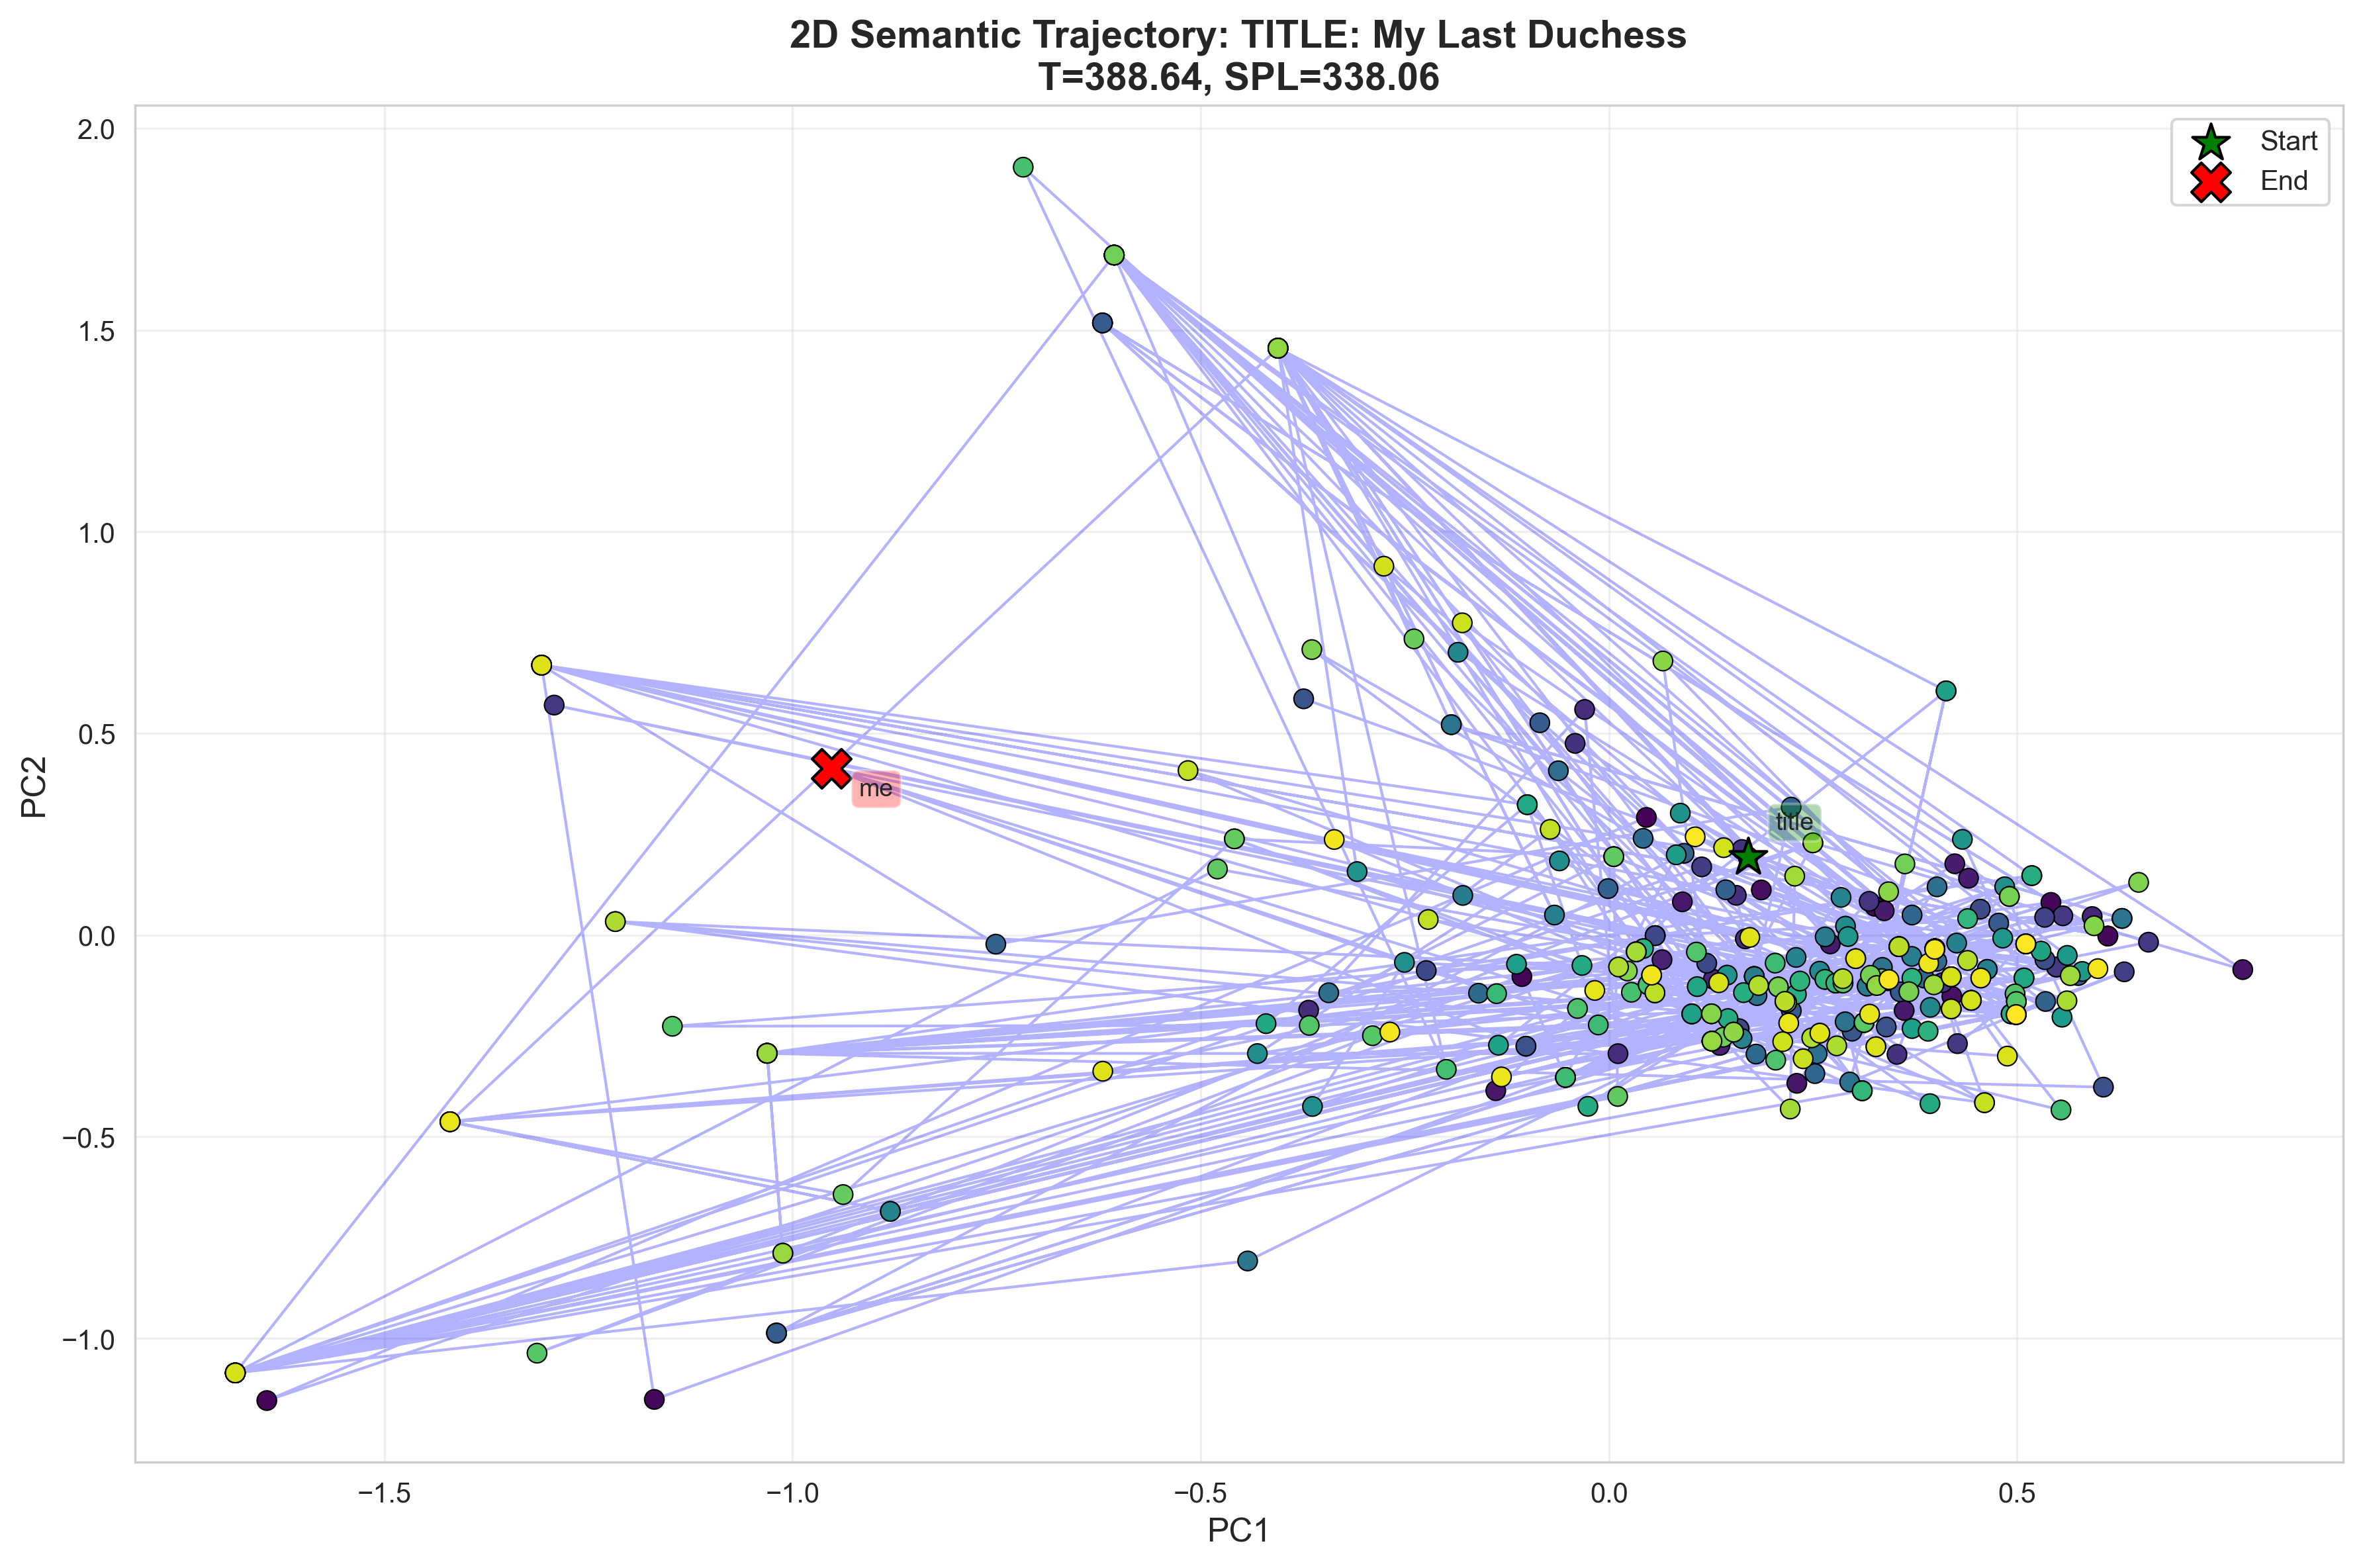


2D Variance explained: PC1=6.2%, PC2=5.4%


In [20]:
# Cell 9: 2D Trajectory Visualization

# PCA to 2D
pca_2d = PCA(n_components=2)
coords_2d = pca_2d.fit_transform(embeddings)

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot trajectory line
ax.plot(coords_2d[:, 0], coords_2d[:, 1], 'b-', alpha=0.3, linewidth=1, zorder=1)

# Plot points with gradient color
colors = plt.cm.viridis(np.linspace(0, 1, len(coords_2d)))
scatter = ax.scatter(coords_2d[:, 0], coords_2d[:, 1], c=colors, s=50, 
                     edgecolors='black', linewidths=0.5, zorder=2)

# Mark start and end
ax.scatter(coords_2d[0, 0], coords_2d[0, 1], color='green', s=200, 
          marker='*', edgecolors='black', linewidths=1, zorder=3, label='Start')
ax.scatter(coords_2d[-1, 0], coords_2d[-1, 1], color='red', s=200, 
          marker='X', edgecolors='black', linewidths=1, zorder=3, label='End')

# Add labels for start/end words
ax.annotate(valid_words[0], (coords_2d[0, 0], coords_2d[0, 1]), 
           xytext=(10, 10), textcoords='offset points', fontsize=9,
           bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.3))
ax.annotate(valid_words[-1], (coords_2d[-1, 0], coords_2d[-1, 1]), 
           xytext=(10, -10), textcoords='offset points', fontsize=9,
           bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3))

ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_title(f'2D Semantic Trajectory: {poem_title}\nT={metrics["tortuosity"]:.2f}, SPL={metrics["spl"]:.2f}', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n2D Variance explained: PC1={pca_2d.explained_variance_ratio_[0]:.1%}, PC2={pca_2d.explained_variance_ratio_[1]:.1%}")

In [ ]:
# Cell 9B: Annotated Trajectory with Key Words at Semantic Turns

# Calculate semantic turns (where direction changes significantly)
def find_semantic_turns(coords, threshold_percentile=75):
    """Find points where the trajectory changes direction significantly."""
    turns = [0]  # Always include start
    
    if len(coords) < 3:
        return turns + [len(coords)-1]
    
    # Calculate angles between consecutive segments
    angles = []
    for i in range(1, len(coords)-1):
        v1 = coords[i] - coords[i-1]
        v2 = coords[i+1] - coords[i]
        
        # Normalize
        n1 = np.linalg.norm(v1)
        n2 = np.linalg.norm(v2)
        
        if n1 > 0 and n2 > 0:
            v1 = v1 / n1
            v2 = v2 / n2
            # Calculate angle (0 = straight, 1 = right angle, 2 = reversal)
            angle = np.arccos(np.clip(np.dot(v1, v2), -1, 1))
            angles.append((i, angle))
    
    if not angles:
        return [0, len(coords)-1]
    
    # Find high-angle turns
    threshold = np.percentile([a[1] for a in angles], threshold_percentile)
    for i, angle in angles:
        if angle > threshold:
            turns.append(i)
    
    turns.append(len(coords)-1)  # Always include end
    return sorted(list(set(turns)))

turns = find_semantic_turns(coords_2d, threshold_percentile=70)

fig, ax = plt.subplots(figsize=(16, 12))

# Plot full trajectory with gradient
points = coords_2d.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors_seg = plt.cm.viridis(np.linspace(0, 1, len(segments)))
lc = LineCollection(segments, colors=colors_seg, linewidths=2.5, alpha=0.7, zorder=1)
ax.add_collection(lc)

# Plot all points
scatter_colors = plt.cm.viridis(np.linspace(0, 1, len(coords_2d)))
ax.scatter(coords_2d[:, 0], coords_2d[:, 1], c=scatter_colors, s=60, 
          edgecolors='black', linewidths=0.8, zorder=2, alpha=0.7)

# Highlight and label turn points
for turn_idx in turns:
    # Larger marker for turn points
    ax.scatter(coords_2d[turn_idx, 0], coords_2d[turn_idx, 1], 
              s=200, c=[scatter_colors[turn_idx]], edgecolors='red', 
              linewidths=3, zorder=3, marker='o')
    
    # Add word label
    word = valid_words[turn_idx]
    position = turn_idx + 1
    
    # Determine label position to avoid overlap
    if turn_idx == 0:
        xytext = (20, 20)
        bbox_color = 'green'
        label = f"START\n#{position}: {word}"
    elif turn_idx == len(coords_2d) - 1:
        xytext = (20, -20)
        bbox_color = 'red'
        label = f"END\n#{position}: {word}"
    else:
        # Alternate label positions
        offset = 20 if turn_idx % 2 == 0 else -20
        xytext = (20, offset)
        bbox_color = 'yellow'
        label = f"#{position}: {word}"
    
    ax.annotate(label, (coords_2d[turn_idx, 0], coords_2d[turn_idx, 1]),
               xytext=xytext, textcoords='offset points', 
               fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.4', facecolor=bbox_color, 
                        alpha=0.8, edgecolor='black', linewidth=1.5),
               arrowprops=dict(arrowstyle='->', lw=1.5, color='black'),
               zorder=4)

# Add directional arrows
arrow_interval = max(1, len(coords_2d) // 10)
for i in range(0, len(coords_2d)-1, arrow_interval):
    if i+1 < len(coords_2d) and i not in turns:  # Don't overlap with turn markers
        dx = coords_2d[i+1, 0] - coords_2d[i, 0]
        dy = coords_2d[i+1, 1] - coords_2d[i, 1]
        ax.arrow(coords_2d[i, 0], coords_2d[i, 1], dx*0.4, dy*0.4,
                head_width=0.15, head_length=0.1, fc=colors_seg[i], 
                ec='black', linewidth=0.5, alpha=0.6, zorder=2)

ax.set_xlabel('PC1 (Semantic Dimension 1)', fontsize=14, fontweight='bold')
ax.set_ylabel('PC2 (Semantic Dimension 2)', fontsize=14, fontweight='bold')
ax.set_title(f'Semantic Trajectory with Key Turns: {poem_title}\nT={metrics["tortuosity"]:.2f}, {len(turns)} major semantic turns detected', 
            fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\n🔄 Detected {len(turns)} semantic turn points (including start/end):")
for turn_idx in turns:
    print(f"  Position {turn_idx+1}: '{valid_words[turn_idx]}'")

In [ ]:
# Cell 9A: IMPROVED 2D Trajectory with Directional Arrows

from matplotlib.patches import FancyArrowPatch
from matplotlib.collections import LineCollection

# PCA to 2D
pca_2d = PCA(n_components=2)
coords_2d = pca_2d.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(16, 12))

# Create colored line segments
points = coords_2d.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors = plt.cm.viridis(np.linspace(0, 1, len(segments)))

# Plot line segments with gradient
lc = LineCollection(segments, colors=colors, linewidths=2, alpha=0.6, zorder=1)
ax.add_collection(lc)

# Add directional arrows at intervals
arrow_interval = max(1, len(coords_2d) // 8)  # ~8 arrows total
for i in range(0, len(coords_2d)-1, arrow_interval):
    if i+1 < len(coords_2d):
        dx = coords_2d[i+1, 0] - coords_2d[i, 0]
        dy = coords_2d[i+1, 1] - coords_2d[i, 1]
        arrow = FancyArrowPatch(
            (coords_2d[i, 0], coords_2d[i, 1]),
            (coords_2d[i, 0] + dx*0.6, coords_2d[i, 1] + dy*0.6),
            arrowstyle='->', mutation_scale=20, linewidth=2,
            color=colors[i], alpha=0.8, zorder=2
        )
        ax.add_patch(arrow)

# Plot points with gradient color and numbered labels
scatter_colors = plt.cm.viridis(np.linspace(0, 1, len(coords_2d)))
ax.scatter(coords_2d[:, 0], coords_2d[:, 1], c=scatter_colors, s=80, 
          edgecolors='black', linewidths=1, zorder=3)

# Add numbers to every Nth point for readability
label_interval = max(1, len(coords_2d) // 10)  # ~10 labels
for i in range(0, len(coords_2d), label_interval):
    ax.annotate(str(i+1), (coords_2d[i, 0], coords_2d[i, 1]), 
               fontsize=8, fontweight='bold', color='white',
               ha='center', va='center', zorder=4)

# Mark start and end prominently
ax.scatter(coords_2d[0, 0], coords_2d[0, 1], color='green', s=300, 
          marker='*', edgecolors='black', linewidths=2, zorder=5, label='Start')
ax.scatter(coords_2d[-1, 0], coords_2d[-1, 1], color='red', s=300, 
          marker='X', edgecolors='black', linewidths=2, zorder=5, label='End')

# Add labels for start/end words
ax.annotate(f"START: {valid_words[0]}", (coords_2d[0, 0], coords_2d[0, 1]), 
           xytext=(15, 15), textcoords='offset points', fontsize=11, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='green', alpha=0.7, edgecolor='black', linewidth=2),
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', linewidth=2))
ax.annotate(f"END: {valid_words[-1]}", (coords_2d[-1, 0], coords_2d[-1, 1]), 
           xytext=(15, -15), textcoords='offset points', fontsize=11, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='red', alpha=0.7, edgecolor='black', linewidth=2),
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', linewidth=2))

ax.set_xlabel('PC1 (Semantic Dimension 1)', fontsize=14, fontweight='bold')
ax.set_ylabel('PC2 (Semantic Dimension 2)', fontsize=14, fontweight='bold')
ax.set_title(f'2D Semantic Trajectory (Enhanced): {poem_title}\nT={metrics["tortuosity"]:.2f}, SPL={metrics["spl"]:.2f}, n={len(valid_words)} words', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\n2D Variance explained: PC1={pca_2d.explained_variance_ratio_[0]:.1%}, PC2={pca_2d.explained_variance_ratio_[1]:.1%}")
print(f"Total: {sum(pca_2d.explained_variance_ratio_):.1%}")
print(f"\nArrows show reading direction, numbers show word position (every ~{label_interval} words)")

In [ ]:
# Cell 11A: Save ENHANCED 2D visualizations for publication

output_dir = Path('Results/Individual_Visualizations')
output_dir.mkdir(parents=True, exist_ok=True)
safe_filename = POEM_FILENAME.replace('.txt', '')

# Save enhanced arrow version
fig, ax = plt.subplots(figsize=(16, 12))
points = coords_2d.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors = plt.cm.viridis(np.linspace(0, 1, len(segments)))
lc = LineCollection(segments, colors=colors, linewidths=2, alpha=0.6, zorder=1)
ax.add_collection(lc)

arrow_interval = max(1, len(coords_2d) // 8)
for i in range(0, len(coords_2d)-1, arrow_interval):
    if i+1 < len(coords_2d):
        dx = coords_2d[i+1, 0] - coords_2d[i, 0]
        dy = coords_2d[i+1, 1] - coords_2d[i, 1]
        arrow = FancyArrowPatch(
            (coords_2d[i, 0], coords_2d[i, 1]),
            (coords_2d[i, 0] + dx*0.6, coords_2d[i, 1] + dy*0.6),
            arrowstyle='->', mutation_scale=20, linewidth=2,
            color=colors[i], alpha=0.8, zorder=2
        )
        ax.add_patch(arrow)

scatter_colors = plt.cm.viridis(np.linspace(0, 1, len(coords_2d)))
ax.scatter(coords_2d[:, 0], coords_2d[:, 1], c=scatter_colors, s=80, 
          edgecolors='black', linewidths=1, zorder=3)

label_interval = max(1, len(coords_2d) // 10)
for i in range(0, len(coords_2d), label_interval):
    ax.annotate(str(i+1), (coords_2d[i, 0], coords_2d[i, 1]), 
               fontsize=8, fontweight='bold', color='white',
               ha='center', va='center', zorder=4)

ax.scatter(coords_2d[0, 0], coords_2d[0, 1], color='green', s=300, 
          marker='*', edgecolors='black', linewidths=2, zorder=5, label='Start')
ax.scatter(coords_2d[-1, 0], coords_2d[-1, 1], color='red', s=300, 
          marker='X', edgecolors='black', linewidths=2, zorder=5, label='End')

ax.annotate(f"START: {valid_words[0]}", (coords_2d[0, 0], coords_2d[0, 1]), 
           xytext=(15, 15), textcoords='offset points', fontsize=11, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='green', alpha=0.7, edgecolor='black', linewidth=2),
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', linewidth=2))
ax.annotate(f"END: {valid_words[-1]}", (coords_2d[-1, 0], coords_2d[-1, 1]), 
           xytext=(15, -15), textcoords='offset points', fontsize=11, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='red', alpha=0.7, edgecolor='black', linewidth=2),
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', linewidth=2))

ax.set_xlabel('PC1 (Semantic Dimension 1)', fontsize=14, fontweight='bold')
ax.set_ylabel('PC2 (Semantic Dimension 2)', fontsize=14, fontweight='bold')
ax.set_title(f'2D Semantic Trajectory: {poem_title}\nT={metrics["tortuosity"]:.2f}, SPL={metrics["spl"]:.2f}, n={len(valid_words)} words', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

output_2d_enhanced = output_dir / f"{safe_filename}_2d_enhanced.png"
plt.savefig(output_2d_enhanced, dpi=300, bbox_inches='tight')
plt.close()

# Save annotated turns version
turns = find_semantic_turns(coords_2d, threshold_percentile=70)
fig, ax = plt.subplots(figsize=(16, 12))

points = coords_2d.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors_seg = plt.cm.viridis(np.linspace(0, 1, len(segments)))
lc = LineCollection(segments, colors=colors_seg, linewidths=2.5, alpha=0.7, zorder=1)
ax.add_collection(lc)

scatter_colors = plt.cm.viridis(np.linspace(0, 1, len(coords_2d)))
ax.scatter(coords_2d[:, 0], coords_2d[:, 1], c=scatter_colors, s=60, 
          edgecolors='black', linewidths=0.8, zorder=2, alpha=0.7)

for turn_idx in turns:
    ax.scatter(coords_2d[turn_idx, 0], coords_2d[turn_idx, 1], 
              s=200, c=[scatter_colors[turn_idx]], edgecolors='red', 
              linewidths=3, zorder=3, marker='o')
    
    word = valid_words[turn_idx]
    position = turn_idx + 1
    
    if turn_idx == 0:
        xytext = (20, 20)
        bbox_color = 'green'
        label = f"START\n#{position}: {word}"
    elif turn_idx == len(coords_2d) - 1:
        xytext = (20, -20)
        bbox_color = 'red'
        label = f"END\n#{position}: {word}"
    else:
        offset = 20 if turn_idx % 2 == 0 else -20
        xytext = (20, offset)
        bbox_color = 'yellow'
        label = f"#{position}: {word}"
    
    ax.annotate(label, (coords_2d[turn_idx, 0], coords_2d[turn_idx, 1]),
               xytext=xytext, textcoords='offset points', 
               fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.4', facecolor=bbox_color, 
                        alpha=0.8, edgecolor='black', linewidth=1.5),
               arrowprops=dict(arrowstyle='->', lw=1.5, color='black'),
               zorder=4)

arrow_interval = max(1, len(coords_2d) // 10)
for i in range(0, len(coords_2d)-1, arrow_interval):
    if i+1 < len(coords_2d) and i not in turns:
        dx = coords_2d[i+1, 0] - coords_2d[i, 0]
        dy = coords_2d[i+1, 1] - coords_2d[i, 1]
        ax.arrow(coords_2d[i, 0], coords_2d[i, 1], dx*0.4, dy*0.4,
                head_width=0.15, head_length=0.1, fc=colors_seg[i], 
                ec='black', linewidth=0.5, alpha=0.6, zorder=2)

ax.set_xlabel('PC1 (Semantic Dimension 1)', fontsize=14, fontweight='bold')
ax.set_ylabel('PC2 (Semantic Dimension 2)', fontsize=14, fontweight='bold')
ax.set_title(f'Semantic Trajectory with Key Turns: {poem_title}\nT={metrics["tortuosity"]:.2f}, {len(turns)} major semantic turns', 
            fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

output_2d_turns = output_dir / f"{safe_filename}_2d_annotated.png"
plt.savefig(output_2d_turns, dpi=300, bbox_inches='tight')
plt.close()

print(f"✓ Saved enhanced 2D (with arrows): {output_2d_enhanced}")
print(f"✓ Saved annotated 2D (with turns): {output_2d_turns}")

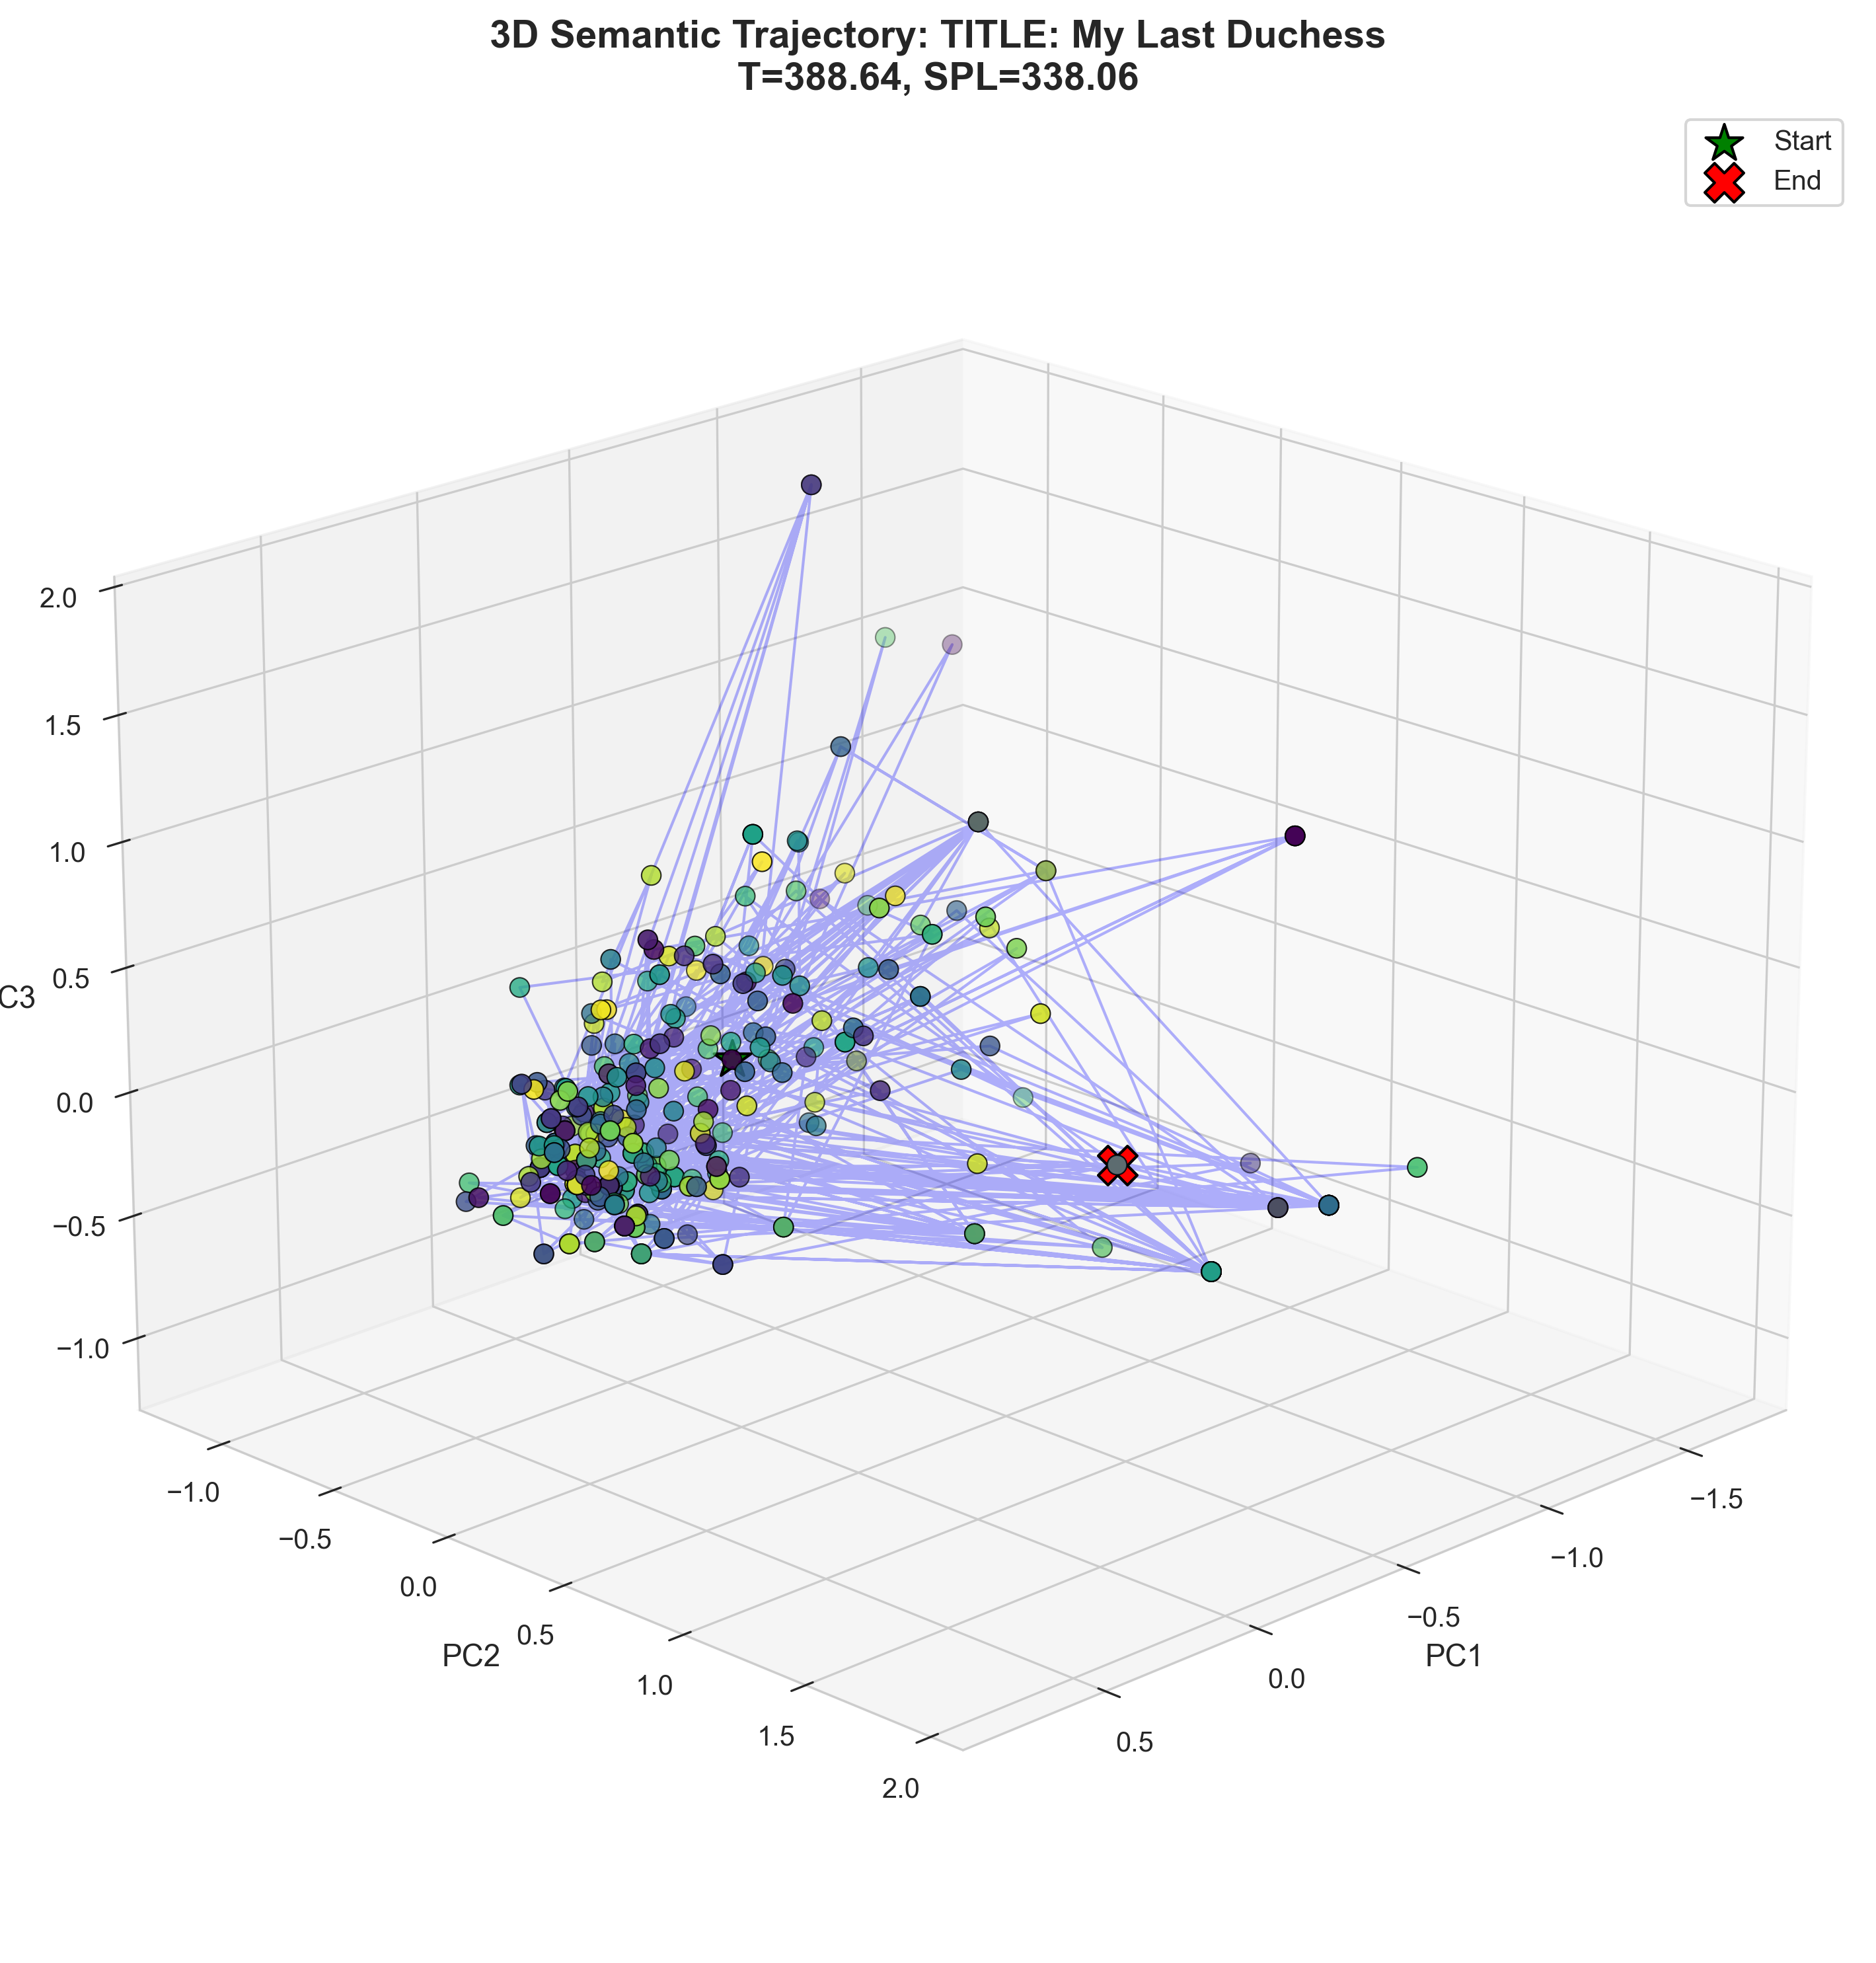


3D Variance explained: PC1=6.2%, PC2=5.4%, PC3=4.0%
Total variance captured: 15.5%


In [21]:
# Cell 10: 3D Trajectory Visualization

# PCA to 3D
pca_3d = PCA(n_components=3)
coords_3d = pca_3d.fit_transform(embeddings)

# Create figure
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory line
ax.plot(coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2], 
        'b-', alpha=0.3, linewidth=1, zorder=1)

# Plot points with gradient color
colors = plt.cm.viridis(np.linspace(0, 1, len(coords_3d)))
scatter = ax.scatter(coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2], 
                     c=colors, s=50, edgecolors='black', linewidths=0.5, zorder=2)

# Mark start and end
ax.scatter(coords_3d[0, 0], coords_3d[0, 1], coords_3d[0, 2], 
          color='green', s=200, marker='*', edgecolors='black', linewidths=1, 
          zorder=3, label='Start')
ax.scatter(coords_3d[-1, 0], coords_3d[-1, 1], coords_3d[-1, 2], 
          color='red', s=200, marker='X', edgecolors='black', linewidths=1, 
          zorder=3, label='End')

ax.set_xlabel('PC1', fontsize=11)
ax.set_ylabel('PC2', fontsize=11)
ax.set_zlabel('PC3', fontsize=11)
ax.set_title(f'3D Semantic Trajectory: {poem_title}\nT={metrics["tortuosity"]:.2f}, SPL={metrics["spl"]:.2f}', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Set viewing angle
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print(f"\n3D Variance explained: PC1={pca_3d.explained_variance_ratio_[0]:.1%}, PC2={pca_3d.explained_variance_ratio_[1]:.1%}, PC3={pca_3d.explained_variance_ratio_[2]:.1%}")
print(f"Total variance captured: {sum(pca_3d.explained_variance_ratio_):.1%}")

In [22]:
# Cell 11: Save 2D and 3D plots

output_dir = Path('Results/Individual_Visualizations')
output_dir.mkdir(parents=True, exist_ok=True)

# Create safe filename from poem title
safe_filename = POEM_FILENAME.replace('.txt', '')

# Recreate and save 2D plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(coords_2d[:, 0], coords_2d[:, 1], 'b-', alpha=0.3, linewidth=1, zorder=1)
colors = plt.cm.viridis(np.linspace(0, 1, len(coords_2d)))
ax.scatter(coords_2d[:, 0], coords_2d[:, 1], c=colors, s=50, 
          edgecolors='black', linewidths=0.5, zorder=2)
ax.scatter(coords_2d[0, 0], coords_2d[0, 1], color='green', s=200, 
          marker='*', edgecolors='black', linewidths=1, zorder=3, label='Start')
ax.scatter(coords_2d[-1, 0], coords_2d[-1, 1], color='red', s=200, 
          marker='X', edgecolors='black', linewidths=1, zorder=3, label='End')
ax.annotate(valid_words[0], (coords_2d[0, 0], coords_2d[0, 1]), 
           xytext=(10, 10), textcoords='offset points', fontsize=9,
           bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.3))
ax.annotate(valid_words[-1], (coords_2d[-1, 0], coords_2d[-1, 1]), 
           xytext=(10, -10), textcoords='offset points', fontsize=9,
           bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3))
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_title(f'2D Semantic Trajectory: {poem_title}\nT={metrics["tortuosity"]:.2f}, SPL={metrics["spl"]:.2f}', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
output_2d = output_dir / f"{safe_filename}_2d.png"
plt.savefig(output_2d, dpi=300, bbox_inches='tight')
plt.close()

# Recreate and save 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2], 
        'b-', alpha=0.3, linewidth=1, zorder=1)
colors = plt.cm.viridis(np.linspace(0, 1, len(coords_3d)))
ax.scatter(coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2], 
          c=colors, s=50, edgecolors='black', linewidths=0.5, zorder=2)
ax.scatter(coords_3d[0, 0], coords_3d[0, 1], coords_3d[0, 2], 
          color='green', s=200, marker='*', edgecolors='black', linewidths=1, 
          zorder=3, label='Start')
ax.scatter(coords_3d[-1, 0], coords_3d[-1, 1], coords_3d[-1, 2], 
          color='red', s=200, marker='X', edgecolors='black', linewidths=1, 
          zorder=3, label='End')
ax.set_xlabel('PC1', fontsize=11)
ax.set_ylabel('PC2', fontsize=11)
ax.set_zlabel('PC3', fontsize=11)
ax.set_title(f'3D Semantic Trajectory: {poem_title}\nT={metrics["tortuosity"]:.2f}, SPL={metrics["spl"]:.2f}', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.view_init(elev=20, azim=45)
plt.tight_layout()
output_3d = output_dir / f"{safe_filename}_3d.png"
plt.savefig(output_3d, dpi=300, bbox_inches='tight')
plt.close()

print(f"✓ Saved 2D plot: {output_2d}")
print(f"✓ Saved 3D plot: {output_3d}")

✓ Saved 2D plot: Results/Individual_Visualizations/024_my_last_duchess_2d.png
✓ Saved 3D plot: Results/Individual_Visualizations/024_my_last_duchess_3d.png


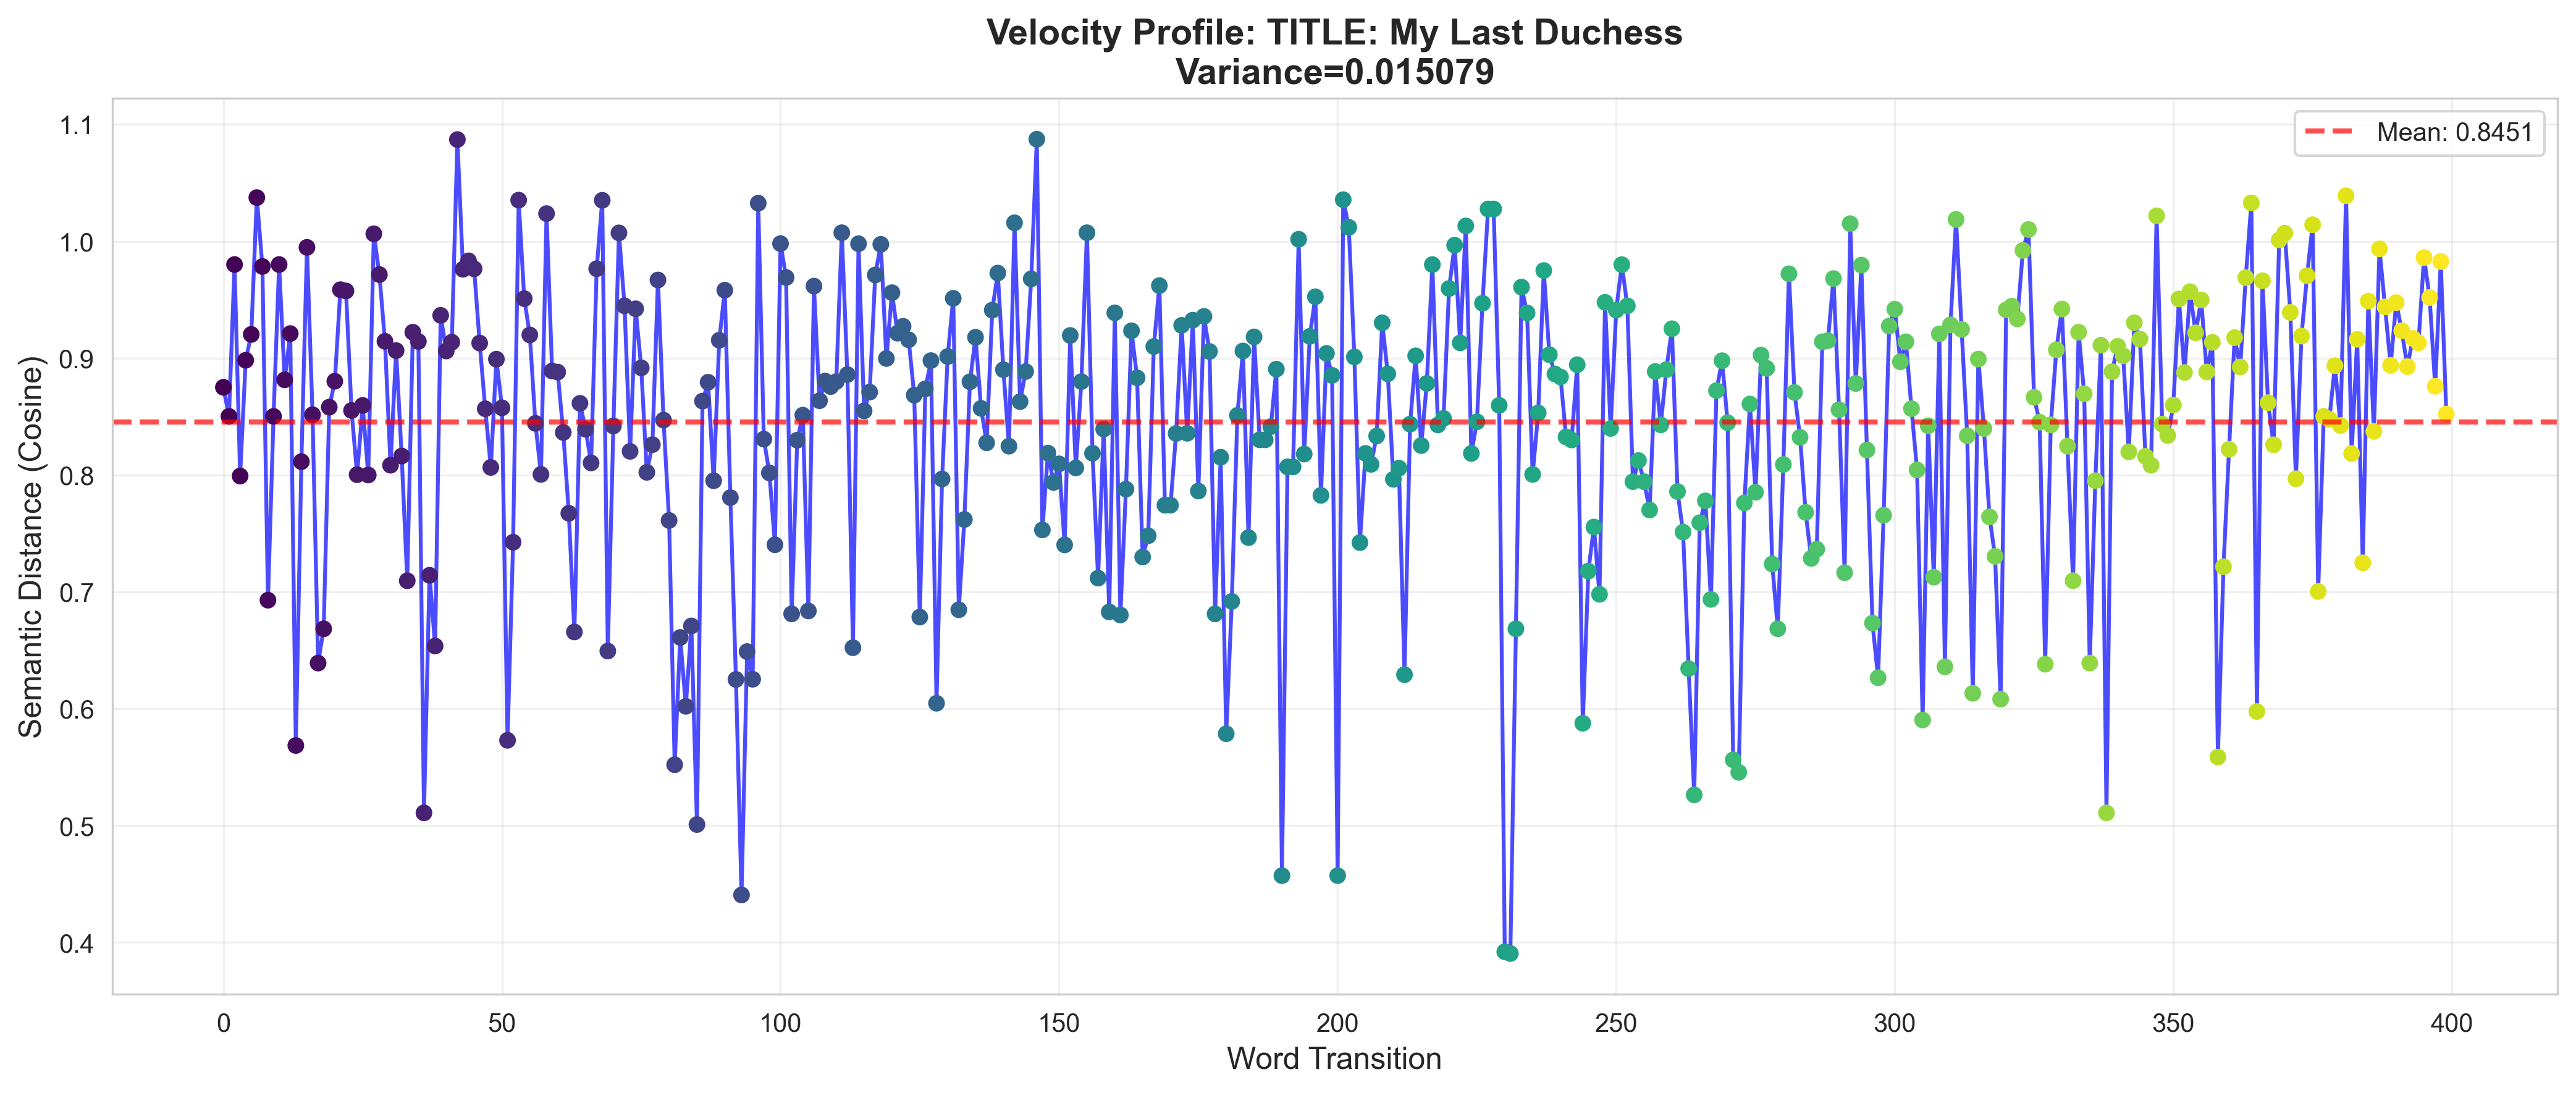


✓ Saved velocity profile: Results/Individual_Visualizations/024_my_last_duchess_velocity.png


In [23]:
# Cell 12: Velocity Profile

# Calculate step-by-step distances
distances = [cosine_distance(embeddings[i], embeddings[i+1]) 
            for i in range(len(embeddings)-1)]

fig, ax = plt.subplots(figsize=(14, 6))

# Plot velocity profile
ax.plot(range(len(distances)), distances, 'b-', linewidth=1.5, alpha=0.7)
ax.scatter(range(len(distances)), distances, c=range(len(distances)), 
          cmap='viridis', s=30, zorder=2)

# Add mean line
mean_dist = np.mean(distances)
ax.axhline(mean_dist, color='red', linestyle='--', linewidth=2, 
          label=f'Mean: {mean_dist:.4f}', alpha=0.7)

ax.set_xlabel('Word Transition', fontsize=12)
ax.set_ylabel('Semantic Distance (Cosine)', fontsize=12)
ax.set_title(f'Velocity Profile: {poem_title}\nVariance={metrics["velocity_variance"]:.6f}', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save velocity profile
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(range(len(distances)), distances, 'b-', linewidth=1.5, alpha=0.7)
ax.scatter(range(len(distances)), distances, c=range(len(distances)), 
          cmap='viridis', s=30, zorder=2)
ax.axhline(mean_dist, color='red', linestyle='--', linewidth=2, 
          label=f'Mean: {mean_dist:.4f}', alpha=0.7)
ax.set_xlabel('Word Transition', fontsize=12)
ax.set_ylabel('Semantic Distance (Cosine)', fontsize=12)
ax.set_title(f'Velocity Profile: {poem_title}\nVariance={metrics["velocity_variance"]:.6f}', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
output_velocity = output_dir / f"{safe_filename}_velocity.png"
plt.savefig(output_velocity, dpi=300, bbox_inches='tight')
plt.close()

print(f"\n✓ Saved velocity profile: {output_velocity}")

In [24]:
# Cell 13: Export metrics to JSON

output_json = output_dir / f"{safe_filename}_metrics.json"

json_data = {
    'poem': poem_title,
    'filename': POEM_FILENAME,
    'metrics': metrics,
    'words': valid_words
}

with open(output_json, 'w', encoding='utf-8') as f:
    json.dump(json_data, f, indent=2, ensure_ascii=False)

print(f"✓ Saved metrics: {output_json}")

✓ Saved metrics: Results/Individual_Visualizations/024_my_last_duchess_metrics.json


In [25]:
# Cell 14: Compare to corpus

# Load corpus results
corpus_results = pd.read_csv('Results/corpus_trajectory_results.csv')

# Find this poem in corpus
poem_row = corpus_results[corpus_results['filename'] == POEM_FILENAME]

if len(poem_row) > 0:
    print("\n" + "="*60)
    print("CORPUS COMPARISON")
    print("="*60)
    
    # Calculate percentiles
    t_percentile = (corpus_results['tortuosity'] < metrics['tortuosity']).sum() / len(corpus_results) * 100
    spl_percentile = (corpus_results['spl'] < metrics['spl']).sum() / len(corpus_results) * 100
    
    print(f"\nThis poem's position in corpus:")
    print(f"  Tortuosity percentile:  {t_percentile:.1f}% (rank {int(t_percentile/100*len(corpus_results))}/{len(corpus_results)})")
    print(f"  SPL percentile:         {spl_percentile:.1f}% (rank {int(spl_percentile/100*len(corpus_results))}/{len(corpus_results)})")
    
    print(f"\nCorpus statistics:")
    print(f"  Mean tortuosity:        {corpus_results['tortuosity'].mean():.2f}")
    print(f"  Median tortuosity:      {corpus_results['tortuosity'].median():.2f}")
    print(f"  This poem:              {metrics['tortuosity']:.2f}")
    
    if 'tortuosity_residual' in poem_row.columns:
        residual = float(poem_row['tortuosity_residual'].iloc[0])
        print(f"\nLength-adjusted tortuosity:")
        print(f"  Residual:               {residual:.4f}")
        if residual > 0.1:
            print(f"  Interpretation:         HIGH (tortuous for its length)")
        elif residual < -0.1:
            print(f"  Interpretation:         LOW (direct for its length)")
        else:
            print(f"  Interpretation:         AVERAGE (typical for its length)")
    
    print("="*60)
else:
    print(f"\nNote: {POEM_FILENAME} not found in corpus results")
    print("(May have failed in corpus analysis due to insufficient vocabulary coverage)")


CORPUS COMPARISON

This poem's position in corpus:
  Tortuosity percentile:  61.2% (rank 30/49)
  SPL percentile:         57.1% (rank 28/49)

Corpus statistics:
  Mean tortuosity:        644.53
  Median tortuosity:      271.90
  This poem:              388.64
